# Go straight to predicting the sentiment of the next utterance

In [1]:
from spacy import displacy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import spacy
import os
from functools import partial

import data
import plot

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from chatty.utils import tokens

train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)
# train[['utter_t-1', 'utter_t-2', 'utter_t-3']] = data.get_lags(train[['utter']], lag_range=[1, 2, 3])

/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


Using Cached


In [579]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
results = data.cv_stratified_shuffle(X[::50], y[::50],
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


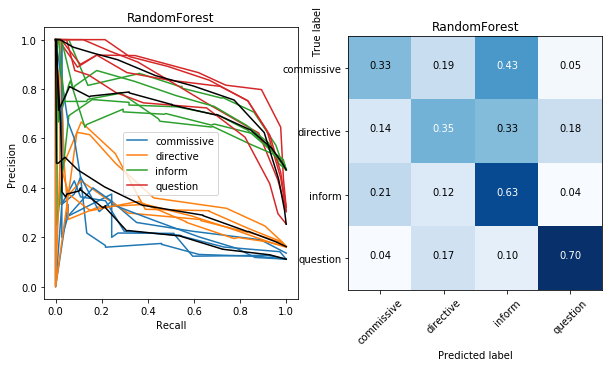

In [7]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

### Predict next emo directly from Pipeline RandomForest on words and pos

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from chatty.utils import tokens
# %reload_ext chatty.utils.tokens

vocab = np.array(tokens.load_vocab('subjects_dependency_pos', 'word_ngram_2')['vocab'])
SPLITTER = "*^"
train['vocab'] = pd.Series(vocab, index=train.index).map(lambda x: SPLITTER.join(x))
train[['vocab_t-1', 'vocab_t-2', 'vocab_t-3']] = data.get_lags(train[['vocab']], lag_range=[1, 2, 3])

ACT_MASK = train['emo'].notnull() \
         & train['vocab_t-1'].notnull() \
         & train['vocab_t-2'].notnull() \
         & train['vocab_t-3'].notnull()

assert train['emo'][train['emo'].notnull()].shape[0] \
      == train_vecs[train['emo'].notnull()].shape[0]

X = train[['vocab_t-3', 'vocab_t-2', 'vocab_t-1']][ACT_MASK].values

y = train['emo'][ACT_MASK].values

In [5]:
from sklearn.pipeline import FeatureUnion

# from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier


def vocab_splitter(tokens: str):
    return tokens.split(SPLITTER)

In [46]:
class CountVectorizerColumnN(object):
    def __init__(self, *args, colnum=None, **kwargs):
        "just like Cou"
        self.countvec = CountVectorizer(*args, **kwargs)
        self.colnum = colnum
        
        
    def fit(self, raw_documents, y=None):
        raw_documents = raw_documents[:, self.colnum]
        self.countvec.fit_transform(raw_documents)
        return self
        
    def transform(self, raw_documents):
        # only interested in one column
        raw_documents = raw_documents[:, self.colnum]
        X = self.countvec.transform(raw_documents)
        return X

fu = FeatureUnion([('vocab_t-3', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=0)),
                   ('vocab_t-2', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=1)),
                   ('vocab_t-1', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=2))])

clf = Pipeline([
    ('feature_union_countvecs', fu),
    ('SMOTE', RandomOverSampler('minority')),
    ('RandomForest', RandomForestClassifier(n_jobs=-1))
])

In [63]:
results = data.cv_stratified_shuffle(X, y,
                                     clf,
                                     splits=2)

Training
Training
Training
Training
Training


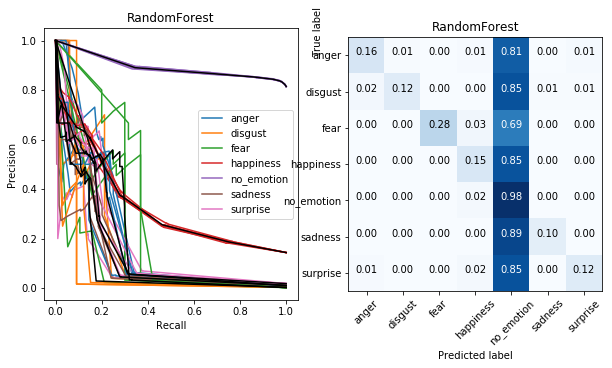

In [64]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

In [68]:
train

person                                              utter  \
conv                                                                    
0     0   person_a                              The kitchen stinks .    
      1   person_b                      I'll throw out the garbage .    
1     0   person_a  So Dick , how about getting some coffee for to...   
      1   person_b   Coffee ? I don ’ t honestly like that kind of...   
      2   person_a   Come on , you can at least try a little , bes...   
      3   person_b   What ’ s wrong with that ? Cigarette is the t...   
      4   person_a                               Not for me , Dick .    
2     0   person_a  Are things still going badly with your housegu...   
      1   person_b   Getting worse . Now he ’ s eating me out of h...   
      2   person_a   Leo , I really think you ’ re beating around ...   
      3   person_b   You ’ re right . Everything is probably going...   
3     0   person_a                  Would you mind waiting a while ?    
      1   person_b                      Well , how long will it be ?    
      2   person_a   I'm not sure . But I'll get a table ready as ...   
      3   person_b                                 OK . We'll wait .    
4     0   person_a  Are you going to the annual party ? I can give...   
      1   person_b   Thanks a lot . That's the favor I was going t...   
      2   person_a                            The pleasure is mine .    
5     0   person_a  Isn ’ t he the best instructor ? I think he ’ ...   
      1   person_b      I swear , I ’ m going to kill you for this .    
      2   person_a   What ’ s wrong ? Didn ’ t you think it was fu...   
      3   person_b   Oh , yeah ! I had a blast ! I love sweating l...   
      4   person_a   Oh , no , get off it . It wasn ’ t such a kil...   
      5   person_b                      I am wiped out . Thank you .    
      6   person_a   Look , next time get yourself some comfy shoe...   
      7   person_b           Never ! But thank you for inviting me .    
      8   person_a   Come on . You ’ ll feel better after we hit t...   
6     0   person_a  Can I take your order now or do you still want...   
      1   person_b   Well , I want a fillet steak , medium , but m...   
      2   person_a   Certainly . How about spaghetti with clams an...   
...            ...                                                ...   
13114 0   person_a  Lindsay Tipping gave me your name as a referen...   
      1   person_b   Lindsay , of course , I will be more than hap...   
      2   person_a     How long was she employed with your company ?    
      3   person_b   She freelanced with us for 3 years . She was ...   
      4   person_a   Freelance , hmm . How do you think she will m...   
      5   person_b   She ’ s a consummate professional and a team-...   
13115 0   person_a  The consignments of chemical instruments have ...   
      1   person_b                         Is there anything wrong ?    
      2   person_a   We bought 1,000 sets of chemical instruments ...   
      3   person_b   It's hard for us to believe it . Our instrume...   
      4   person_a   Here is the survey report from a well-known p...   
      5   person_b   Well . According to the contract , we are res...   
      6   person_a   Forty faulty instruments means that 4 % are n...   
      7   person_b   I am sorry about the quality problem , but I ...   
      8   person_a   All right . In that case we are still willing...   
13117 0   person_a   May I ask you a few questions about insurance ?    
      1   person_b                                             Yes .    
      2   person_a   Now we've given a CIF Shanghai price for some...   
      3   person_b   Well . Obviously , you won ’ t want All Risks...   
      4   person_a                                         Why not ?    
      5   person_b   Because they aren ’ t delicate goods and won ...   
      6   person_a   Then am I right in understanding that FPA doe... 

### Feedback from Orson

- Difference in distribution of features like:
    - Word Length
    - Noun Count
    - Verb Count
    - Etc.
- 